# Imbalanced Classification: One-Class Algorithms for Imbalanced Classification

### Main techniques used:
* Scaling
* Normalization
* **One-Class Support Vector Machines**
* **Isolation Forests**
* **Minimum Covariance Determinant (MCD/ Elliptic Envelope)**
* **Local Outlier Factor**

### Background:
* The Oil Spill Classification dataset is an example of an imbalanced classification problem where a class label is required, and both positive and negative classes are equally important. (Detecting and acting on a spill is an expensive response, so false positives are bad. However it is also equally expensive and bad to miss an oil spill event.)
* In this project, we will utilize various One-Class Algorithm Classifiers for Imbalanced Classification tasks.

In [1]:
# Import necessary libraries

from matplotlib import pyplot
from collections import Counter

from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from imblearn.metrics import geometric_mean_score
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from numpy import vstack

from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from numpy import arange

### Simple EDA of the data

(937, 50)
Class = 1.0, Count = 41, Percentage = 4.376%
Class = 0.0, Count = 896, Percentage = 95.624%


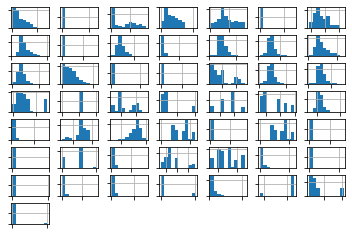

In [2]:
filename = 'oil-spill.csv'
dataframe = read_csv(filename, header=None)
print(dataframe.shape)

target = dataframe.values[:,-1]
counter = Counter(target)
for k, v in counter.items():
    per = v / len(target) * 100
    print(f"Class = {k}, Count = {v}, Percentage = {per:.3f}%")
    
ax = dataframe.hist()
for axis in ax.flatten():
    axis.set_title('')
    axis.set_xticklabels([])
    axis.set_yticklabels([])
pyplot.show()

**Note:** We can see that the target class distribution is quite imbalanced.

**Note:** We can also see that there are many different distributions, and we expect that scaling and using power transforms may be useful, before proceeding to modelling.

In [3]:
# Define a few custom functions

def load_dataset(full_path):
    # load the dataset as a numpy array
    data = read_csv(full_path, header=None)
    # drop unused columns
    data.drop(22, axis=1, inplace=True)
    data.drop(0, axis=1, inplace=True)
    # retrieve numpy array
    data = data.values
    # split into input and output elements
    X, y = data[:, :-1], data[:, -1]
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    return X, y

In [4]:
# define the location of the dataset
full_path = 'oil-spill.csv'

# load the dataset
X, y = load_dataset(full_path)

# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))

(937, 47) (937,) Counter({0: 896, 1: 41})


In [5]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=88,
                                               stratify=y)

In [7]:
# Mark inliers as 1, outliers as -1
testy[testy == 1] = -1
testy[testy == 0] = 1

In [8]:
# Count examples in each class
counter = Counter(trainy)
# Estimate ratio of minority class, to be used as ratio of outliers.
estimate = counter[1]/(counter[0]+counter[1])
print(f"The ratio of outliers is approximately: {estimate:.4f}")

The ratio of outliers is approximately: 0.0443


In [9]:
def get_models():
    models, names = list(), list()
    models.append(OneClassSVM(gamma='scale', nu=0.05))
    names.append('OCSVM')
    models.append(IsolationForest(contamination=0.05))
    names.append('IsoForest')
    models.append(EllipticEnvelope(contamination=0.05))
    names.append('MCD')
    return models, names

In [10]:
print(len(trainX))
print(len(trainy))

655
655


In [11]:
# We will fit the models on majority class only
trainX = trainX[trainy==0]

In [12]:
# Define models here
models, names = get_models()

In [13]:
results = list()

# Evaluate each model here
for i in range(len(models)):
    models[i].fit(trainX)
    yhat = models[i].predict(testX)
    # Evaluate models and store results
    scores = f1_score(testy, yhat, pos_label=-1)
    # Summarize and store the scores
    print(f"{names[i]}: {scores}")
    results.append(scores)

OCSVM: 0.10810810810810811
IsoForest: 0.15384615384615383


C:\Users\User\anaconda3\envs\vnwk\lib\site-packages\sklearn\covariance\_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


MCD: 0.0


### Local Outlier Factor algorithm

In [14]:
# make a prediction with a lof model
def lof_predict(model, trainX, testX):
    # create one large dataset
    composite = vstack((trainX, testX))
    # make prediction on composite dataset
    yhat = model.fit_predict(composite)
    # return just the predictions on the test set
    return yhat[len(trainX):]


In [15]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.3, random_state=88,
                                               stratify=y)

# define outlier detection model
model = LocalOutlierFactor(contamination=0.05)
# get examples for just the majority class
trainX = trainX[trainy==0]
# detect outliers in the test set
yhat = lof_predict(model, trainX, testX)
# mark inliers 1, outliers -1
testy[testy == 1] = -1
testy[testy == 0] = 1
# calculate score
score = f1_score(testy, yhat, pos_label=-1)
print('F-measure for Local Outlier Factor (LOF): %.3f' % score)


F-measure for Local Outlier Factor (LOF): 0.444


**Note:**
* We can see that it is possible to use one-class classification algorithms for imbalanced datasets.
* One-class classification is a field of ML that provides techniques for outlier and anomaly identification.
* It may also be possible to explore combining outlier predictions from these one-class classification algorithms, with the other imbalanced classification algorithms previously explored. This may help with identifying the minority class by tackling it from 2 different perspectives.